# Leverage deployment guardrails to update a SageMaker Inference endpoint using rolling deployment


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/sagemaker-inference-deployment-guardrails|Update-SageMaker-Inference-endpoint-using-rolling-deployment.ipynb)

---


SageMaker Studio Kernel: Data Science

# Contents

 - [Introduction](#Introduction)
 - [Setup](#Setup)
 - [Step 1: Create and deploy the pre-trained models](#Step1)
 - [Step 2: Invoke Endpoint](#Step2)
 - [Step 3: Create CloudWatch alarms to monitor Endpoint performance](#Step3)
 - [Step 4: Update Endpoint with rolling deployment configurations](#Step4)
 - [Cleanup](#Clenup)

# Introduction <a id='Introduction'></a>

Deployment guardrails are a set of model deployment options in Amazon SageMaker Inference to update your machine learning models in production. Using the fully managed deployment guardrails options, you can control the switch from the current model in production to a new one.

When you update your endpoint, you can specify a rolling deployment to gradually shift traffic from your old fleet to a new fleet. You can control the size of the traffic shifting steps, as well as specify an evaluation period to monitor the new instances for issues before terminating instances from the old fleet. With rolling deployments, instances on the old fleet are cleaned up after each traffic shift to the new fleet, reducing the amount of additional instances needed to update your endpoint. This is useful especially for accelerated instances that are in high demand.

Rolling deployments work similarly to the linear traffic shifting mode in blue/green deployments, but rolling deployments provide you with the added benefit fewer capacity needs. Compared to blue/green deployments with canary or linear traffic shifting modes, rolling deployments can also have lower costs. With rolling deployments, fewer instances are active at a time, and you have more granular control over how many instances you want to update in the new fleet. You should consider using a rolling deployment instead of a blue/green deployment if you have large models or a large endpoint with many instances.

The following list describes the key features of rolling deployments in SageMaker:

* **Baking period**. The baking period is a set amount of time to monitor the new fleet before proceeding to the next deployment stage. If any of the pre-specified alarms trip during any baking period, then all endpoint traffic rolls back to the old fleet. The baking period helps you to build confidence in your update before making the traffic shift permanent.
* **Rolling batch size**. You have granular control over the size of each batch for traffic shifting, or the number of instances you want to update in each batch. This number can range for 5-50% of the size of your fleet. You can specify the batch size as a number of instances or as the overall percentage of your fleet.
* **Auto-rollbacks**. You can specify Amazon CloudWatch alarms that SageMaker uses to monitor the new fleet. If an issue with the updated code trips any of the alarms, SageMaker initiates an auto-rollback to the old fleet in order to maintain availability, thereby minimizing risk.


In this notebook we'll update endpoint with following deployment configurations:
 * Rolling update policy
 * Configure CloudWatch alarms to monitor model performance and trigger auto-rollback action.
  
To demonstrate rolling deployments and the auto-rollback feature, we will update an Endpoint with an incompatible model version and deploy it as a Rolling fleet, taking a small percentage of the traffic. Requests sent to this Rolling fleet will result in errors, which will be used to trigger a rollback using pre-specified CloudWatch alarms. Finally, we will also demonstrate a success scenario where no alarms are tripped and the update succeeds. 

This notebook is organized in 4 steps -
* Step 1 creates the models and Endpoint Configurations required for the 3 scenarios - the baseline, the update containing the incompatible model version and the update containing the correct model version. 
* Step 2 invokes the baseline Endpoint prior to the update. 
* Step 3 specifies the CloudWatch alarms used to trigger the rollbacks. 
* Finally in step 4, we update the endpoint to trigger a rollback and demonstrate a successful update. 


Reference: https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/deployment-guardrails-rolling.html

# Setup <a id='Setup'></a>

First we ensure we have an updated version of boto3, which includes the latest SageMaker features:

In [ ]:
!pip install -U awscli
!pip install sagemaker

Let's set up some required imports and basic initial variables:

In [ ]:
%matplotlib inline

import time
import os
import boto3
import botocore
import re
import json
import sagemaker
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

# region = boto3.Session().region_name

# You can use a different IAM role with SageMakerFullAccess policy for this notebook
role = get_execution_role()
print(f"Execution role: {role}")
sess = sagemaker.session.Session()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-Deployment-Guardrails-Rolling"
region = sess._region_name # region name of the current SageMaker Studio environment
account_id = sess.account_id()

Download the Input files and pre-trained model from S3 bucket

# Step 1: Create and deploy the models <a id='Step1'></a>

### Upload models to Amazon S3

In [ ]:
s3_model_url = "s3://<your-bucket-name>/test_1012/" # 原始 whisper 模型
s3_model_url2 = "s3://<your-bucket-name>/whisper/" # 与现有镜像不适配的 model，模拟部署失败的场景
s3_model_url3 = "s3://<your-bucket-name>/test_lora/" # lora 微调后的模型

print(f"Model URI 1: {s3_model_url}")
print(f"Model URI 2: {s3_model_url2}")
print(f"Model URI 2: {s3_model_url3}")

In [ ]:
# !cat {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh
PROJECT_ROOT="/home/ec2-user/SageMaker/whisper-sagemaker-triton" # Modify this path to your own project root

s3_prefix = "whisper-rolling-deploy-demo"
## Compress and upload base model code_artifact
!sed -i "s|S3_PATH=.*|S3_PATH=\"{s3_model_url}\"|"  {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh 
!cat {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh
!rm model_date.tar.gz
!cat model_data/deploy_config.sh
!tar czvf model_data1.tar.gz model_data/ --exclude=model_data/.ipynb_checkpoints --exclude=model_data/__pycache__


## Compress and upload incompatible model code_artifact
!sed -i "s|S3_PATH=.*|S3_PATH=\"{s3_model_url2}\"|"  {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh 
!cat {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh
!rm model_date.tar.gz
!cat model_data/deploy_config.sh
!tar czvf model_data2.tar.gz model_data/ --exclude=model_data/.ipynb_checkpoints --exclude=model_data/__pycache__


## Compress and upload finetuned model code_artifact
!sed -i "s|S3_PATH=.*|S3_PATH=\"{s3_model_url3}\"|"  {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh 
!cat {PROJECT_ROOT}/sagemaker_triton/model_data/deploy_config.sh
!rm model_date.tar.gz
!cat model_data/deploy_config.sh
!tar czvf model_data3.tar.gz model_data/ --exclude=model_data/.ipynb_checkpoints --exclude=model_data/__pycache__


In [ ]:
s3_code_prefix ="whisper-rolling-deploy-demo"
bucket = sess.default_bucket()
code_artifact1 = sess.upload_data("model_data1.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact1}")

code_artifact2 = sess.upload_data("model_data2.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact2}")

code_artifact3 = sess.upload_data("model_data3.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact3}")
!rm model_data1.tar.gz model_data2.tar.gz model_data3.tar.gz 

### Create model definitions
Start with deploying models. Here, you create the model objects with the image and model data.

In [5]:
# login ECR
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com


REPO_NAME = "sagemaker-endpoint/whisper-triton-byoc"
image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{REPO_NAME}:latest"

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [6]:
model_name1 = f"DEMO-whisper-ASR1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-whisper-ASR2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-whisper-ASR3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Model Name 1: {model_name1}")
print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")

resp = sm.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": code_artifact1}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": code_artifact2}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": code_artifact3}],
)
print(f"Created Model: {resp}")

Model Name 1: DEMO-whisper-ASR1-2024-10-17-01-39-16
Model Name 2: DEMO-whisper-ASR2-2024-10-17-01-39-16
Model Name 3: DEMO-whisper-ASR3-2024-10-17-01-39-16
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:596899493901:model/DEMO-whisper-ASR1-2024-10-17-01-39-16', 'ResponseMetadata': {'RequestId': '75985df6-4ccd-40a2-b05b-b251f848066e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '75985df6-4ccd-40a2-b05b-b251f848066e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '99', 'date': 'Thu, 17 Oct 2024 01:39:17 GMT'}, 'RetryAttempts': 0}}
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:596899493901:model/DEMO-whisper-ASR2-2024-10-17-01-39-16', 'ResponseMetadata': {'RequestId': '7a5827ad-3fb0-4c65-ac06-e5eace7fba4e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7a5827ad-3fb0-4c65-ac06-e5eace7fba4e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '99', 'date': 'Thu, 17 Oct 2024 01:39:19 GMT'}, 'RetryAttempts': 2}}


### Create Endpoint Configs

We now create three EndpointConfigs, each with its own different model (these could also have different instance types).


In [ ]:
ep_config_name = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 1: {ep_config_name}")
print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name1,
            "InstanceType": "ml.g5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.g5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

### Create Endpoint

Let's go ahead and deploy the model to a SageMaker endpoint:

In [ ]:
endpoint_name = f"DEMO-Deployment-Guardrails-Rolling-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

# creating endpoint with the first endpoint config (ep_config_name)
resp = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=ep_config_name)
print(f"\nCreated Endpoint: {resp}")

Wait for the endpoint creation to complete.

In [9]:
%%time
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
..................
Done!
CPU times: user 91.6 ms, sys: 8.43 ms, total: 100 ms
Wall time: 9min 1s


{'EndpointName': 'DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-10-17-01-39-23',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc:latest',
     'ResolvedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc@sha256:a1365baaa3de065eb363df16e1e13d5fa813b289f11ad6e78bcd586a5810fb95',
     'ResolutionTime': datetime.datetime(2024, 10, 17, 1, 39, 42, 598000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 10, 17, 1, 39, 41, 921000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024

# Step 2: Invoke Endpoint <a id='Step2'></a>

You can now send data to this endpoint to get inferences in real time.

This step invokes the endpoint with included sample data with maximum invocations count and waiting intervals. 

In [10]:
import boto3
import json
import base64
import os
import io
from pydub import AudioSegment

endpoint_name = endpoint_name
def encode_audio(audio_file_path):
    # 加载音频文件
    audio = AudioSegment.from_wav(audio_file_path)
    
    # 检查是否为双通道
    if audio.channels == 2:
        print("检测到双通道音频，正在转换为单通道...")
        # 将双通道转换为单通道
        audio = audio.set_channels(1)
    
    # 将音频数据写入内存缓冲区
    buffer = io.BytesIO()
    audio.export(buffer, format="wav")
    buffer.seek(0)
    
    # 将缓冲区的内容编码为 base64
    return base64.b64encode(buffer.read()).decode('utf-8')

def invoke_sagemaker_endpoint(runtime_client, endpoint_name, audio_data, language="", repo_id="whisper-large-v3", decoding_method="greedy_search", whisper_prompt=""):
    """Invoke SageMaker endpoint with audio data"""
    payload = {
        "language": language,
        "repo_id": repo_id,
        "decoding_method": decoding_method,
        "whisper_prompt": whisper_prompt,
        "audio_data": audio_data
    }
    
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(payload)
    )
    
    result = json.loads(response['Body'].read().decode())
    return result

def transcribe_audio(audio_path, endpoint_name, language="", repo_id="whisper-large-v3", decoding_method="greedy_search", whisper_prompt=""):
    # Convert audio to 16kHz mono WAV if it's not already
    # Read and encode the audio file
    print("Reading and encoding audio file...")
    audio_data = encode_audio(audio_path)

    # Create a SageMaker runtime client
    runtime_client = boto3.client('sagemaker-runtime')

    # Invoke the SageMaker endpoint
    print(f"Invoking SageMaker endpoint: {endpoint_name}")
    result = invoke_sagemaker_endpoint(
        runtime_client,
        endpoint_name,
        audio_data,
        language,
        repo_id,
        decoding_method,
        whisper_prompt
    )

    return result

# Example usage
if __name__ == "__main__":
    # Set your parameters here
    audio_path = "./English_04.wav"
    language = "en"  # For now, this parameter is not being used; the language will be specified by the prompt.
    repo_id = "whisper-large-v3"  # Optional: change the model if needed
    decoding_method = "greedy_search"  # Optional: change the decoding method if needed
    whisper_prompt = ""  # Optional: add a prompt if needed, the defualt is <|startoftranscript|><|en|><|transcribe|><|notimestamps|>

    # Call the function
    result = transcribe_audio(audio_path, endpoint_name, language, repo_id, decoding_method, whisper_prompt)

    # Print the result
    print("Transcription result:")
    print(result)


Reading and encoding audio file...
Invoking SageMaker endpoint: DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41
Transcription result:
{'code': 0, 'message': 'Success', 'transcribe_text': ' I want to play Sawyer.'}


In [12]:
%%time
result = transcribe_audio(audio_path, endpoint_name, language, repo_id, decoding_method, whisper_prompt)

# Print the result
print("Transcription result:")
print(result)

Reading and encoding audio file...
Invoking SageMaker endpoint: DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41
Transcription result:
{'code': 0, 'message': 'Success', 'transcribe_text': ' I want to play Sawyer.'}
CPU times: user 12.8 ms, sys: 4.89 ms, total: 17.7 ms
Wall time: 219 ms


In [13]:
# Create a SageMaker runtime client
runtime_client = boto3.client('sagemaker-runtime')
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    audio_data = encode_audio(audio_path)

    # Invoke the SageMaker endpoint
    print(f"Invoking SageMaker endpoint: {endpoint_name}")
    for i in range(2600):
        try:
            result = invoke_sagemaker_endpoint(
                runtime_client,
                endpoint_name,
                audio_data,
                language,
                repo_id,
                decoding_method,
                whisper_prompt
            )
            # print(result)
            # print(f".{i} {result}", end="", flush=True)
            print(".", end="", flush=True)
        except Exception as e:
            print("E", end="", flush=True)
            if should_raise_exp:
                raise e
        count += 1
        if count > max_invocations:
            break
        time.sleep(wait_interval_sec)
    print("\nDone!")


In [14]:
invoke_endpoint(endpoint_name, wait_interval_sec=1, max_invocations=100)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41. 
Please wait...
Invoking SageMaker endpoint: DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41
.....................................................................................................
Done!


### Invocations Metrics

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) per variant and endpoint configuration in Amazon CloudWatch.

Let’s query CloudWatch to get number of Invocations and latency metrics per variant and endpoint configuration.

In [15]:
import pandas as pd

cw = boto3.Session().client("cloudwatch", region_name=region)


def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

### Plot endpoint invocation metrics:

Below, we are going to plot graphs to show the Invocations,Invocation4XXErrors,Invocation5XXErrors,ModelLatency and OverheadLatency against the Endpoint.

You will observe that there should be a flat line for Invocation4XXErrors and Invocation5XXErrors as we are using the correct model version and configs. 
Additionally, ModelLatency and OverheadLatency will start decreasing over time.

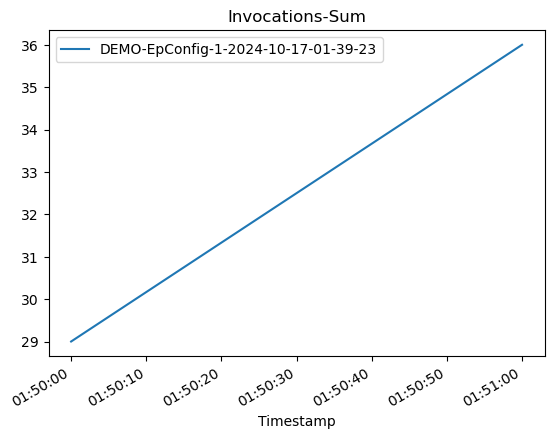

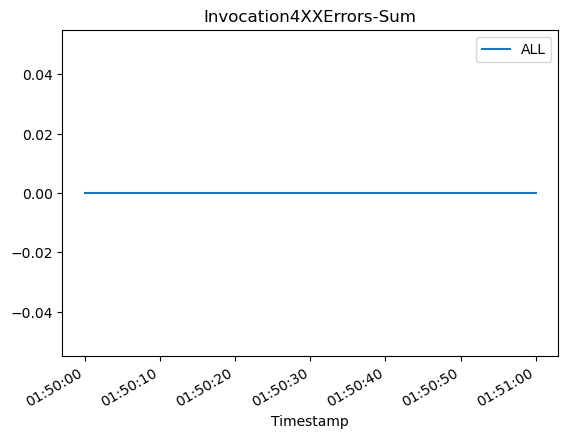

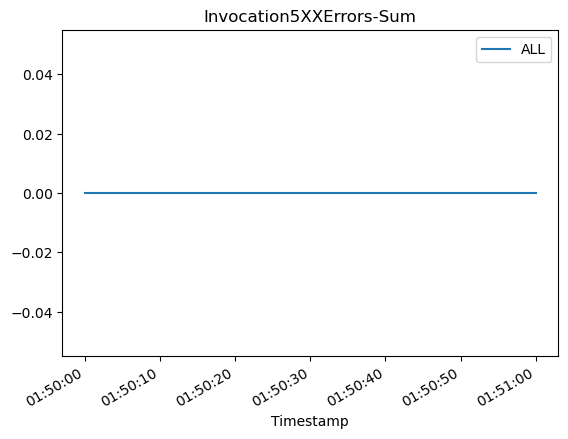

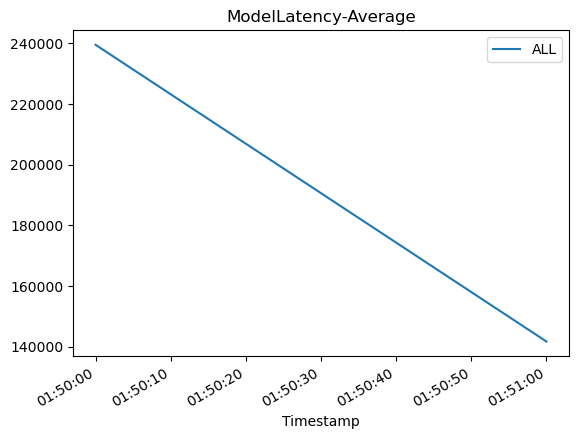

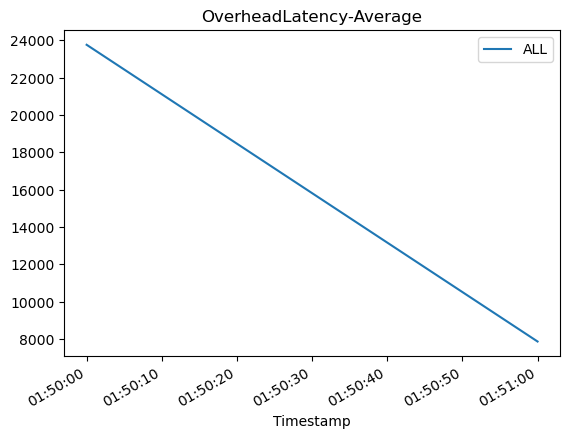

In [16]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

# Step 3: Create CloudWatch alarms to monitor Endpoint performance <a id='Step3'></a>

In this step we're going to create CloudWatch alarms to monitor Endpoint performance with following metrics:
* Invocation5XXErrors
* ModelLatency

Following metric dimensions are used to select the metric per Endpoint config and variant:
* EndpointName
* VariantName


In [17]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [18]:
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"


# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 0.1
)
# alarm on model latency >= 800 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 800000
)


In [27]:
# invocation_alarm = f"TestAlarm-InvocationModelErrors-{endpoint_name}"
# create_auto_rollback_alarm(
#     invocation_alarm, endpoint_name, "AllTraffic", "InvocationModelErrors", "Average", 1
# )

In [19]:
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])
time.sleep(60)

# Step 4: Update Endpoint with rolling deployment configurations <a id='Step4'></a>

Now we try to update the endpoint with rolling deployment configurations and monitor the performance from CloudWatch metrics.


### Rolling update policy

We define the following deployment configuration to perform Rolling deployment strategy. The rolling deployment provisions capacity and shifts traffic to a new fleet in steps of a batch size that you specify. Instances on the new fleet are updated with the new deployment configuration, and if no alarms trip during the baking period, then SageMaker cleans up instances on the old fleet.

### Rollback Case
![Rollback case](images/scenario-rolling-rollback.png)

Update the Endpoint with an incompatible model version to simulate errors and trigger a rollback.

In [20]:
rolling_deployment_config = {
    "RollingUpdatePolicy": {
        "MaximumBatchSize": {
            "Type": "CAPACITY_PERCENT",
            "Value": 33,  # 33% of whole fleet capacity (33% * 3 = 1 instance)
        },
        "WaitIntervalInSeconds": 180,  # wait for 3 minutes before enabling traffic on the rest of fleet
        "MaximumExecutionTimeoutInSeconds": 5000,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}], # "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}, {"AlarmName": invocation_alarm}],
    },
}

# update endpoint request with new DeploymentConfig parameter
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=rolling_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'ResponseMetadata': {'RequestId': 'e6dc7c0c-7458-4b13-9420-0fcef9a6a207',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e6dc7c0c-7458-4b13-9420-0fcef9a6a207',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Thu, 17 Oct 2024 01:57:23 GMT'},
  'RetryAttempts': 0}}

In [21]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-10-17-01-39-23',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc:latest',
     'ResolvedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc@sha256:a1365baaa3de065eb363df16e1e13d5fa813b289f11ad6e78bcd586a5810fb95',
     'ResolutionTime': datetime.datetime(2024, 10, 17, 1, 39, 42, 598000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'CreationTime': datetime.datetime(2024, 10, 17, 1, 39, 41, 921000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024,

### We invoke the endpoint during the update operation is in progress.

**Note : Invoke endpoint in this notebook is in single thread mode, to stop the invoke requests please stop the cell execution**

The E's denote the errors generated from the incompatible model version in the rolling fleet.

The purpose of the below cell is to simulate errors in the rolling fleet. Since the nature of traffic shifting to the rolling fleet is probabilistic, you should wait until you start seeing errors. Then, you may proceed to stop the execution of the below cell. If not aborted, cell will run for 600 invocations.

In [ ]:
invoke_endpoint(endpoint_name, wait_interval_sec=1, max_invocations=1000)

Wait for the update operation to complete and verify the automatic rollback.

In [24]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-10-17-01-39-23',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc:latest',
     'ResolvedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc@sha256:a1365baaa3de065eb363df16e1e13d5fa813b289f11ad6e78bcd586a5810fb95',
     'ResolutionTime': datetime.datetime(2024, 10, 17, 1, 39, 42, 598000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-5XXErrors-DEMO-Dep

Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.

You can expect to see as the new endpoint config-2 (erroneous due to model version) starts getting deployed, it encounters failure and leads to the rollback to endpoint config-1. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency increases during this rollback phase


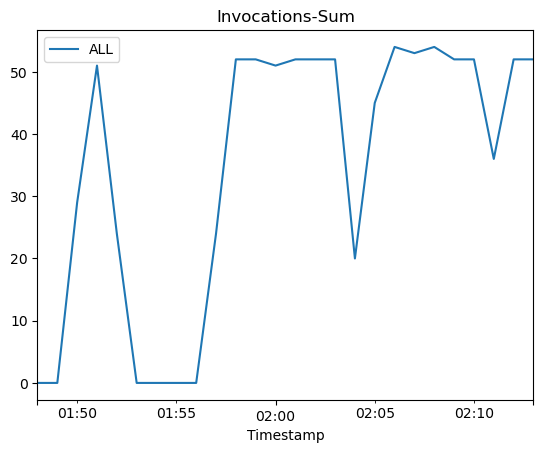

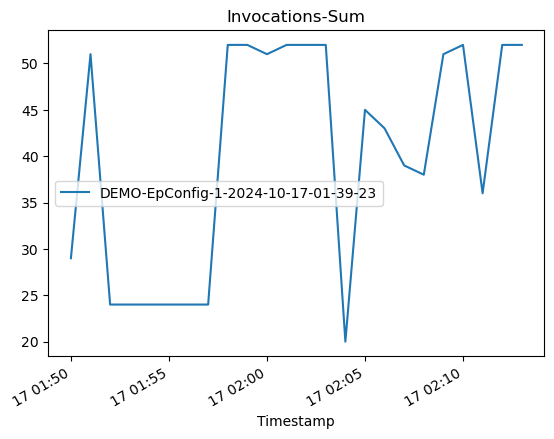

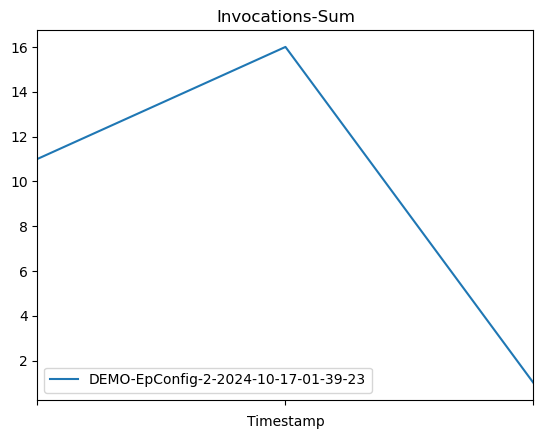

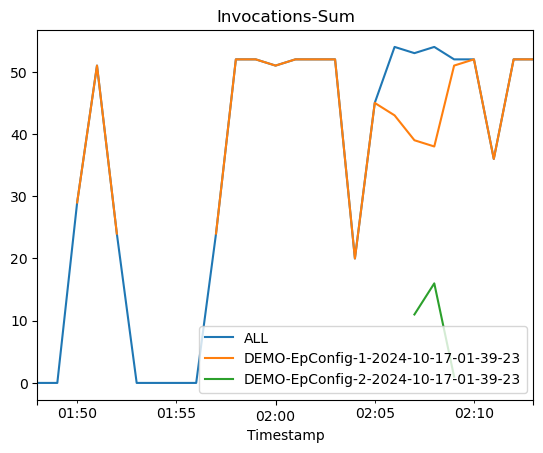

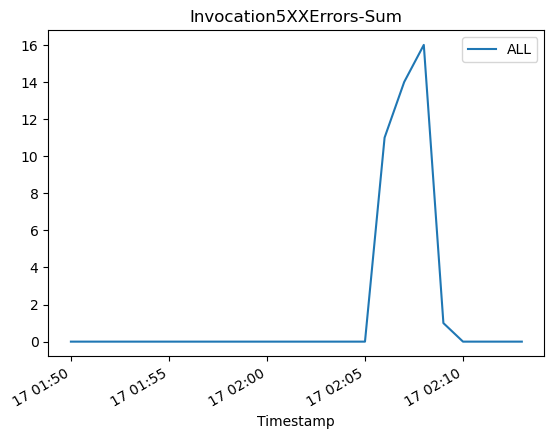

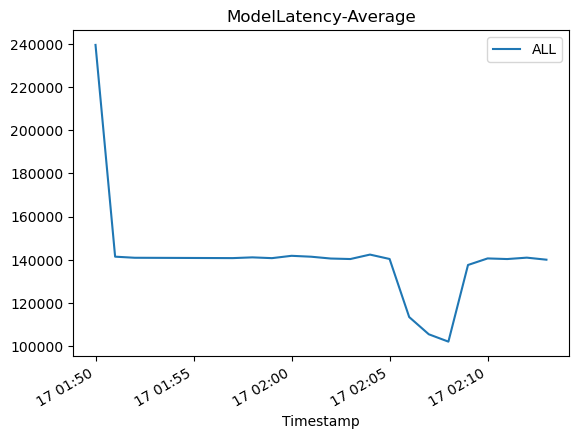

In [27]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

Let's take a look at the Success case where we use the same Rolling deployment configuration but a valid endpoint configuration.

### Success Case


Now let's update the endpoint to a valid endpoint configuration version with the same Rolling deployment configuration:

In [29]:
# update endpoint with a valid version of model with rolling deployment configuration

sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name3,
    RetainDeploymentConfig=True
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'ResponseMetadata': {'RequestId': 'a768d4f4-3bfd-40dd-9ab7-3ba6d392bba2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a768d4f4-3bfd-40dd-9ab7-3ba6d392bba2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Thu, 17 Oct 2024 02:15:13 GMT'},
  'RetryAttempts': 0}}

In [30]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-10-17-01-39-23',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc:latest',
     'ResolvedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc@sha256:a1365baaa3de065eb363df16e1e13d5fa813b289f11ad6e78bcd586a5810fb95',
     'ResolutionTime': datetime.datetime(2024, 10, 17, 1, 39, 42, 598000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-5XXErrors-DEMO-Depl

We invoke the endpoint during the update operation is in progress:

In [31]:
invoke_endpoint(endpoint_name, wait_interval_sec=1, max_invocations=2500)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41. 
Please wait...
Invoking SageMaker endpoint: DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Wait for the update operation to complete:

In [36]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:596899493901:endpoint/DEMO-Deployment-Guardrails-Rolling-2024-10-17-01-39-41',
 'EndpointConfigName': 'DEMO-EpConfig-3-2024-10-17-01-39-23',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc:latest',
     'ResolvedImage': '596899493901.dkr.ecr.us-east-1.amazonaws.com/sagemaker-endpoint/whisper-triton-byoc@sha256:a1365baaa3de065eb363df16e1e13d5fa813b289f11ad6e78bcd586a5810fb95',
     'ResolutionTime': datetime.datetime(2024, 10, 17, 2, 15, 14, 704000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 10, 17, 1, 39, 41, 921000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024

Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.

You can expect to see that, as the new endpoint config-3 (correct model version) starts getting deployed, it takes over endpoint config-2 (erroneous due to model version) without any errors. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency decreases during this transition phase


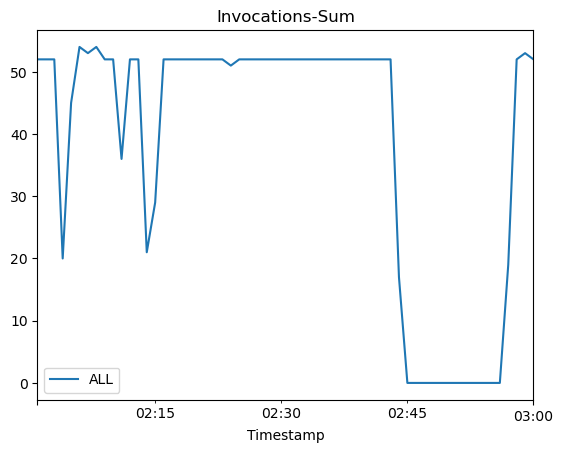

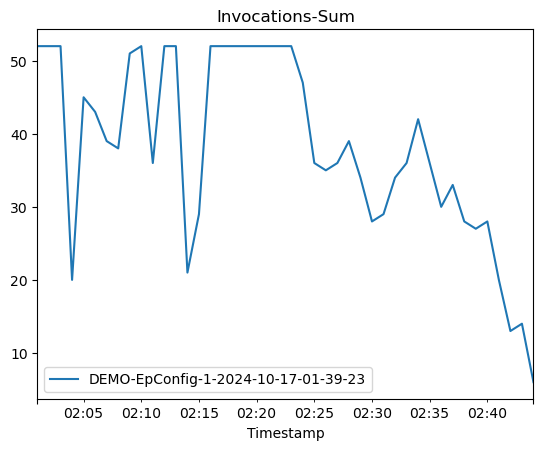

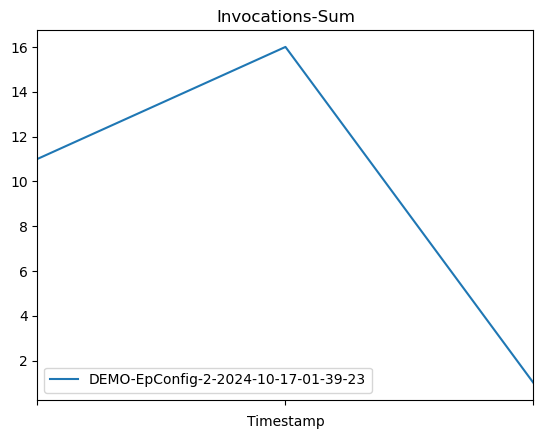

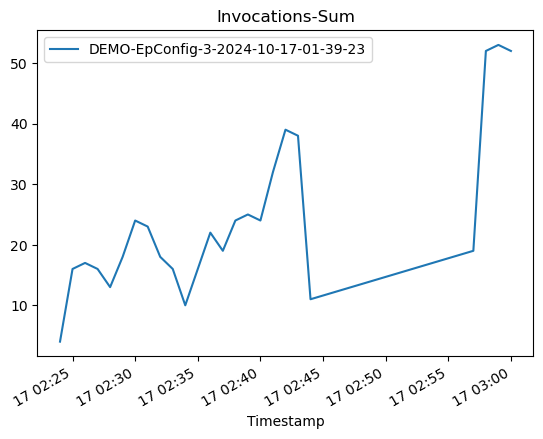

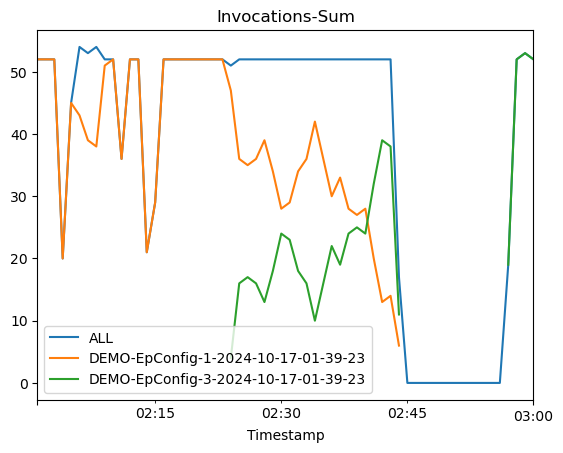

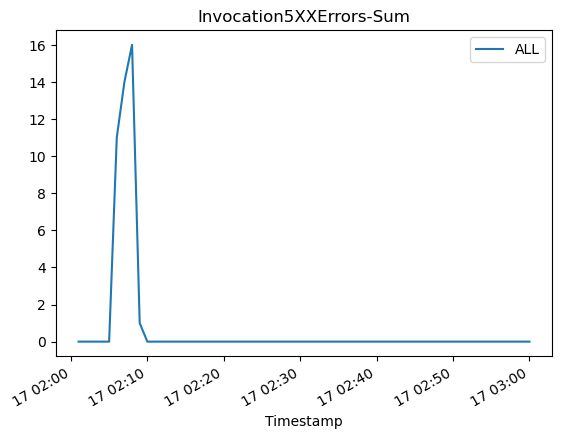

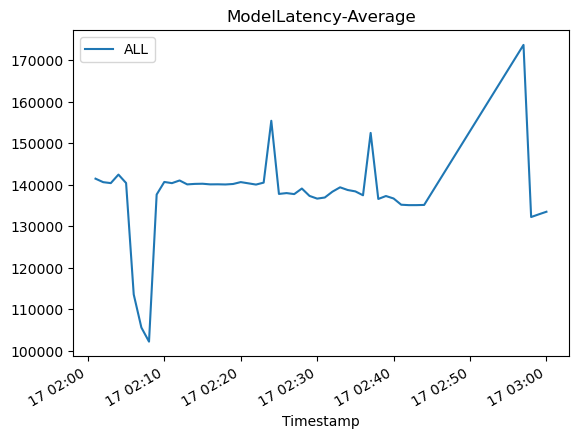

In [37]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
# print(metrics_epc_1)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)
# print(metrics_epc_2)
metrics_epc_3 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name3, "AllTraffic", "Invocations", "Sum"
)
# print(metrics_epc_3)
metrics_all = invocation_metrics.join([metrics_epc_1,metrics_epc_3], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

The Amazon CloudWatch metrics for the total invocations for each endpoint config shows how invocation requests are shifted from the old version to the new version during deployment.

You can now safely update your endpoint and monitor model regressions during deployment and trigger auto-rollback action.

# Cleanup <a id='Cleanup'></a>

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges.

You should also clean up the other resources created in this notebook: endpoint configurations, models, and CloudWatch alarms.

In [38]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'd7b15609-7808-4f1a-aa0f-19d3e383f751',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd7b15609-7808-4f1a-aa0f-19d3e383f751',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 17 Oct 2024 03:07:10 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [39]:
sm.delete_endpoint_config(EndpointConfigName=ep_config_name)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name2)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name3)

{'ResponseMetadata': {'RequestId': '36252993-7612-4f08-9e6f-41477edd0864',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '36252993-7612-4f08-9e6f-41477edd0864',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 17 Oct 2024 03:07:16 GMT',
   'content-length': '0'},
  'RetryAttempts': 2}}

In [44]:
sm.delete_model(ModelName=model_name1)
sm.delete_model(ModelName=model_name2)
sm.delete_model(ModelName=model_name3)

{'ResponseMetadata': {'RequestId': '0a4379b3-a9cd-42cc-a641-866907a33f09',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0a4379b3-a9cd-42cc-a641-866907a33f09',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 16 Oct 2024 14:43:32 GMT',
   'content-length': '0'},
  'RetryAttempts': 3}}

In [45]:
cw.delete_alarms(AlarmNames=[error_alarm, latency_alarm])

{'ResponseMetadata': {'RequestId': '45000618-38de-42ec-84f4-a51fcf8e3b9e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '45000618-38de-42ec-84f4-a51fcf8e3b9e',
   'content-type': 'text/xml',
   'content-length': '210',
   'date': 'Wed, 16 Oct 2024 14:43:37 GMT'},
  'RetryAttempts': 0}}